In [23]:
import pandas as pd
import re
import numpy as np
from sklearn import linear_model
from collections import Counter
import matplotlib.pyplot as plt

#stopwords to remove from text
fp = open('../data/stopwords.txt', 'r');
stpwrds = fp.readlines();
stopwords = [w[:-1] for w in stpwrds];
fp.close()

#clean text to extract words from raw data
def getFeature(rawData):  
    #res =  rawData.split(';');
    res =  re.split(r'\W+', rawData);
    res = ' '.join([word.lower() for word in res if (word.isalpha() and word not in stopwords)]);
    return res;

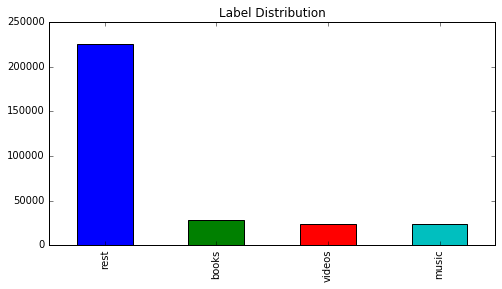

In [24]:
#Read training data
trainData = pd.read_csv("../data/bmv_training_set.csv");

#Analysis of the label distribution plot for the given data
fig, ax = plt.subplots(figsize=[8,4], nrows=1, ncols=1)
trainData['label'].value_counts().plot(ax=ax, kind='bar', title='Label Distribution')
#print(data.groupby('label').count())

In [25]:
# Preprocessing to extract features from the raw text descriptions for all products
x_train = list(trainData['additionalAttributes'].map(lambda a: getFeature(a)));

In [26]:
# Using TF-IDF features 
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts_level1 = count_vect.fit_transform(x_train)
#print count_vect.vocabulary_
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf_level1 = tfidf_transformer.fit_transform(X_train_counts_level1)

In [27]:
# Rest (0) vs (Music, Videos, Books) (1)
trainData['class'] = pd.Series(1, index=trainData.index);
trainData.loc[trainData['label'].str.contains("rest"), 'class'] = 0;
y_level1 = trainData['class']

#Build Level1 classifier
logreg_level1 = linear_model.LogisticRegression(C=1e5)
logreg_level1.fit(X_train_tfidf_level1, y_level1)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [28]:
#show prediction accuracy on training set
predict_level1 = logreg_level1.predict(X_train_tfidf_level1)
np.mean(predict_level1 == y_level1)
#Counter(predict_level1)

0.9991866666666667

In [29]:
# Music (1) vs Books (2) vs Videos (3)
trainData.loc[trainData['label'].str.contains("music"), 'class'] = 1
trainData.loc[trainData['label'].str.contains("books"), 'class'] = 2
trainData.loc[trainData['label'].str.contains("videos"), 'class'] = 3

idx1 = trainData.index[trainData['label'].str.contains("music")].tolist();
idx2 = trainData.index[trainData['label'].str.contains("books")].tolist();
idx3 = trainData.index[trainData['label'].str.contains("videos")].tolist();
idx = (idx1 + idx2 + idx3);
y_train = trainData['class'];
y_level2 = [y_train[id] for id in idx];
x_level2 = [x_train[id] for id in idx];
X_train_counts_level2 = count_vect.transform(x_level2)
X_train_tfidf_level2 = tfidf_transformer.transform(X_train_counts_level2)

#Build Level2 classifier
logreg_level2 = linear_model.LogisticRegression(C=1e5)
logreg_level2.fit(X_train_tfidf_level2, y_level2)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [30]:
predict_level2 = logreg_level2.predict(X_train_tfidf_level2)
np.mean(predict_level2 == y_level2)
#Counter(predict_level2)

print round(np.mean(predict_level1 == y_level1)*np.mean(predict_level2 == y_level2)*100, 2),
print "% of training can be explained by a two level Logistic Regression Model\n"

82.72 % of training can be explained by a two level Logistic Regression Model



In [31]:
#Read test data for predictions
testData = pd.read_csv("../data/bmv_test_set.csv");
x_test = list(testData['additionalAttributes'].map(lambda a: getFeature(a)));
X_test_counts = count_vect.transform(x_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

#Make predictions on test data
testPredict_level1 = logreg_level1.predict(X_test_tfidf);   #Level1 Classifier
testPredict_level2 = logreg_level2.predict(X_test_tfidf);   #Level2 Classifier

In [32]:
#Final prediction on a test data is a result of combination of the Level1 and Level2 Classifiers. 
testPredict = [id[0]*id[1] for id in zip(testPredict_level1, testPredict_level2)];
print Counter(testPredict)

Counter({1: 15375, 0: 15160, 3: 14844, 2: 14621})


In [33]:
#Save prediction on test data into a csv file
testData = pd.concat([testData, pd.Series(testPredict).rename("label")], axis=1)
testData['class'] = pd.Series("rest", index=testData.index);
testData.loc[testData['label'] == 1, 'class'] = "music"
testData.loc[testData['label'] == 2, 'class'] = "books"
testData.loc[testData['label'] == 3, 'class'] = "videos"
testData.drop(['label'], axis = 1, inplace = True)
testData.rename(columns={'class': 'label_logReg'}, inplace=True);
#testData.to_csv('submission_logReg.csv', encoding='utf-8', index=False);
#print testData

In [34]:
#decision tree fit for the given data
from sklearn import tree
decTree = tree.DecisionTreeRegressor()
X = X_train_tfidf_level1;
y = trainData['class']
decTree = decTree.fit(X, y)
print round(decTree.score(X, y)*100, 2),
print "% of training can be explained by Decision Tree Regression Model\n"

Xt = X_test_tfidf;
testPredict_decTree = decTree.predict(Xt);

99.5 % of training can be explained by Decision Tree Regression Model



In [35]:
#Save prediction on test data into a csv file
testData = pd.concat([testData, pd.Series([int(t) for t in testPredict_decTree]).rename("label")], axis=1)
#testData['label_decTee'] = [int(t) for t in testPred];
testData['class'] = pd.Series("rest", index=testData.index);
testData.loc[testData['label'] == 1, 'class'] = "music"
testData.loc[testData['label'] == 2, 'class'] = "books"
testData.loc[testData['label'] == 3, 'class'] = "videos"
testData.drop(['label'], axis = 1, inplace = True)
testData.rename(columns={'class': 'label_decTree'}, inplace=True);
testData.to_csv('submission.csv', encoding='utf-8', index=False);
print testData

           id                               additionalAttributes label_logReg  \
0           0  Movie Genre=Sports & Recreation;Store Item Num...       videos   
1           1  author=Francis Ford Coppola featuring Marlon B...       videos   
2           2  Performer=Phil Hamilton;Record Label=SELECT-O-...        music   
3           7                                       Color=Chrome         rest   
4           9                          Format=Hardcover - $12.82        books   
5          11  Store Item Number (DPCI)=244-24-9046;Origin=Ma...        music   
6          12  Format=Hardcover;Copyright Year=2011;Series Na...        books   
7          13                                        size=48lin.         rest   
8          15                              author=Linos-Ensemble        music   
9          25  format=dvd;Age Group=Adult, Teen;Movie Genre=d...       videos   
10         34  UPC:=5050740022119;Manufacturer:=Sold-Out Soft...         rest   
11         36  Store Item Nu

In [36]:
#from sklearn.svm import SVC
#clf = SVC()
#clf.fit(X, y)
#clf.predict(Xt)